In [8]:
import numpy as np
import pandas as pd
import pystan

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
fish = pd.read_csv('input/fish-num-data.csv')
fish

,fish_num,weather,temperature
0,0,cloudy,5.5
1,2,cloudy,21.1
2,5,cloudy,17.2
3,1,cloudy,5.0
4,3,cloudy,28.3
...,...,...,...
95,0,sunny,5.9
96,0,sunny,12.8
97,0,sunny,2.8
98,0,sunny,3.5


⿂の釣獲尾数は0以上の整数を取る離散型のデータ

→⿂の釣獲尾数にポアソン分布を仮定し、天気および気温のデータが⿂の釣獲尾数に与える影響を予測するポアソン回帰モデルを作成する



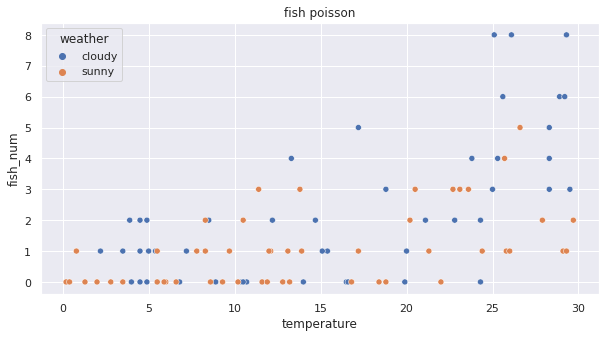

In [9]:
plt.figure(figsize=(10, 5))
sns.set(style='darkgrid')
sns.scatterplot(x='temperature', y='fish_num', data=fish, hue='weather')
plt.title('fish poisson')
plt.show()

In [55]:
fish_conv = pd.get_dummies(fish.drop(['fish_num'], axis=1),drop_first=True)
fish_conv

,temperature,weather_sunny
0,5.5,0
1,21.1,0
2,17.2,0
3,5.0,0
4,28.3,0
...,...,...
95,5.9,1
96,12.8,1
97,2.8,1
98,3.5,1


In [11]:
stan_data = {
    'N': fish.shape[0], 
    'fish_num':fish['fish_num'],
    'temp':fish['temperature'],
    'sunny':fish_conv['weather_sunny']
    }
stan_data

{'N': 100, 'fish_num': 0     0
 1     2
 2     5
 3     1
 4     3
      ..
 95    0
 96    0
 97    0
 98    0
 99    0
 Name: fish_num, Length: 100, dtype: int64, 'sunny': 0     0
 1     0
 2     0
 3     0
 4     0
      ..
 95    1
 96    1
 97    1
 98    1
 99    1
 Name: weather_sunny, Length: 100, dtype: uint8, 'temp': 0      5.5
 1     21.1
 2     17.2
 3      5.0
 4     28.3
       ... 
 95     5.9
 96    12.8
 97     2.8
 98     3.5
 99    13.2
 Name: temperature, Length: 100, dtype: float64}

説明変数が天気および気温、目的変数が⿂の釣獲尾数である

$\lambda=a+b X$

$y \sim$ PoissonLog $(\lambda)$

のポアソン回帰モデルを作る

In [42]:
stan_code = '''
data {
  int N;                    // データ数
  int fish_num[N];         // 釣獲尾数
  vector[N] temp;         // 気温
  vector[N] sunny;        // 天気(晴れ)
}

parameters {
  real a;            // 切片
  real b_temp;      // 係数(気温)
  real b_sunny;     // 係数(晴れ)
}

model {
  vector[N] lambda = a + b_temp*temp + b_sunny*sunny;
  fish_num ~ poisson_log(lambda);
}

generated quantities {
    vector[N] lambda_pred_sunny;
    vector[N] lambda_pred_cloudy;
    vector[N] y_pred_sunny;
    vector[N] y_pred_cloudy;
    
    for(i in 1:N){
        lambda_pred_sunny[i] = a +  b_temp*temp[i] + b_sunny*1;
        lambda_pred_cloudy[i] = a +  b_temp*temp[i] + b_sunny*0;
        y_pred_sunny[i]  = poisson_log_rng(lambda_pred_sunny[i]);
        y_pred_cloudy[i] = poisson_log_rng(lambda_pred_cloudy[i]);
    }
}
'''

In [43]:
model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_da196b40f501b5b99fa52f07dc41aaf6 NOW.


In [44]:
fit = model.sampling(data=stan_data, n_jobs=1)

In [45]:
mcmc_sample = fit.extract()

In [46]:
result_lambda_cloudy = pd.DataFrame(np.zeros([len(fish), 3])) 
result_lambda_sunny = pd.DataFrame(np.zeros([len(fish), 3])) 

for i in range(len(fish)):
    result_lambda_cloudy.iloc[i,:] = np.percentile(mcmc_sample['lambda_pred_cloudy'][:,i], q=[2.5, 50, 97.5])
    result_lambda_sunny.iloc[i,:] = np.percentile(mcmc_sample['lambda_pred_sunny'][:,i], q=[2.5, 50, 97.5])
    
result_lambda_cloudy.columns = ["2.5%", "50%", "97.5%"]
result_lambda_sunny.columns = ["2.5%", "50%", "97.5%"]

result_lambda_cloudy['temperature'] = fish['temperature']
result_lambda_sunny['temperature'] = fish['temperature']

result_lambda_cloudy = result_lambda_cloudy.sort_values('temperature')
result_lambda_sunny = result_lambda_sunny.sort_values('temperature')

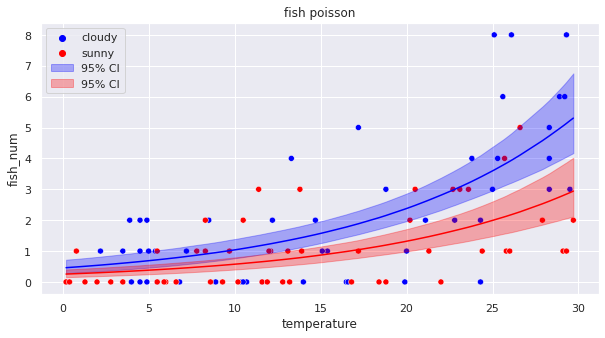

In [53]:
#95%ベイズ信用区間
plt.figure(figsize=(10, 5))

sns.scatterplot(x='temperature',y='fish_num',data=fish,hue='weather',hue_order=['cloudy', 'sunny'],palette=['blue', 'red'])

plt.plot(result_lambda_cloudy['temperature'],np.exp(result_lambda_cloudy["50%"]),color='blue')
plt.fill_between(x=result_lambda_cloudy['temperature'], y1=np.exp(result_lambda_cloudy["2.5%"]), y2=np.exp(result_lambda_cloudy["97.5%"]),color='blue',alpha=0.3,label='95% CI')

plt.plot(result_lambda_sunny['temperature'],np.exp(result_lambda_sunny["50%"]), color='red')
plt.fill_between(x=result_lambda_sunny['temperature'],y1=np.exp(result_lambda_sunny["2.5%"]),y2=np.exp(result_lambda_sunny["97.5%"]),color='red',alpha=0.3,label='95% CI')

plt.title('fish poisson')
plt.legend()

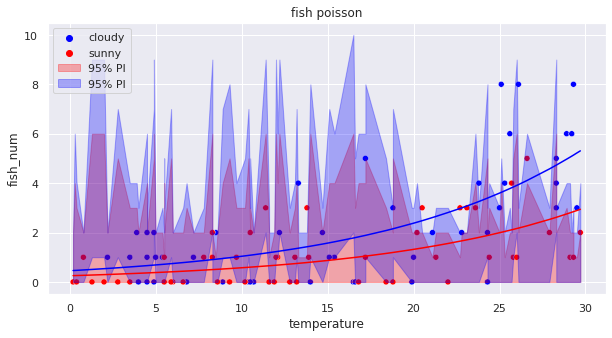

In [50]:
#95%ベイズ予測区間
y_pred_sunny_95 = np.quantile(fit["y_pred_sunny"],axis=0, q=[0.025,0.975]) 
y_pred_cloudy_95 = np.quantile(fit["y_pred_cloudy"],axis=0, q=[0.025,0.975]) 

plt.figure(figsize=(10, 5))
sns.scatterplot(x='temperature',y='fish_num',data=fish,hue='weather',hue_order=['cloudy', 'sunny'],palette=['blue', 'red'])

plt.plot(result_lambda_sunny['temperature'],np.exp(result_lambda_sunny["50%"]), color='red')
plt.fill_between(result_lambda_sunny['temperature'], y_pred_sunny_95[0], y_pred_sunny_95[1], color='red', alpha=0.3, label='95% PI')

plt.plot(result_lambda_cloudy['temperature'],np.exp(result_lambda_cloudy["50%"]),color='blue')
plt.fill_between(result_lambda_cloudy['temperature'], y_pred_cloudy_95[0], y_pred_cloudy_95[1], color='blue', alpha=0.3, label='95% PI')

plt.title('fish poisson')
plt.legend()